In [1]:
from tensorflow import keras
from keras.layers import StringLookup

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from pathlib import Path
import os

np.random.seed(123)
tf.random.set_seed(123)

2023-03-15 16:26:44.852314: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 16:26:45.015747: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-15 16:26:45.019651: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-15 16:26:45.019664: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
BASEDIR = Path(os.getcwd())
DESTDIR = BASEDIR / "etl_output"
MODLDIR = BASEDIR / "models"
SRCDATA = BASEDIR / "data"
DATASET = str(DESTDIR / "words.dts")

In [3]:
lines = open(f"{SRCDATA}/words.txt", "r").readlines()
words_list = list(filter(lambda s: s[0] != "#" and s.split(" ")[1] != "err", lines))
np.random.shuffle(words_list)
words_list[:10]

['k04-079-09-06 ok 180 1655 2391 229 114 JJ ducal\n',
 'l01-050-05-09 ok 180 1952 1578 75 52 RB21 at\n',
 'g04-007-04-04 ok 164 1509 1592 101 164 IN for\n',
 'c04-098-01-03 ok 160 762 969 169 66 NN pianist\n',
 'h04-055-07-01 ok 185 631 2304 44 26 IN in\n',
 'a01-063-00-06 ok 152 1708 747 54 67 AT a\n',
 'a06-004-07-05 ok 185 1666 2012 36 37 AT a\n',
 'f07-084b-02-06 ok 169 1369 1289 63 52 IN in\n',
 'a01-122u-06-00 ok 172 343 1853 74 67 INO of\n',
 'c03-081a-08-01 ok 182 569 2243 78 73 INO of\n']

In [4]:
def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for file_line in samples:
        line_split = file_line.split(" ")

        image_name = line_split[0]
        partI, partII = image_name.split("-")[:2]
        img_path = SRCDATA / "words" / partI / f"{partI}-{partII}" / f"{image_name}.png"
        if img_path.is_file():
            paths.append(str(img_path))
            corrected_samples.append(file_line.strip())
    return paths, corrected_samples

image_paths, image_labels = get_image_paths_and_labels(words_list)

In [5]:
image_paths[:3]

['/home/ventus/Documents/HandwritingRecognition/data/words/k04/k04-079/k04-079-09-06.png',
 '/home/ventus/Documents/HandwritingRecognition/data/words/l01/l01-050/l01-050-05-09.png',
 '/home/ventus/Documents/HandwritingRecognition/data/words/g04/g04-007/g04-007-04-04.png']

In [6]:
# Find maximum length and the size of the vocabulary in the training data.
clean_labels = []
characters = set()
max_len = 0

for label in image_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    clean_labels.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
clean_labels[:10]

Maximum length:  21
Vocab size:  78


['ducal', 'at', 'for', 'pianist', 'in', 'a', 'a', 'in', 'of', 'of']

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

2023-03-15 16:26:50.360961: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-15 16:26:50.360990: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-15 16:26:50.361011: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora): /proc/driver/nvidia/version does not exist
2023-03-15 16:26:50.361405: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

In [9]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


In [10]:
dataset = prepare_dataset(image_paths[:50000] + image_paths[53000:87000], clean_labels[:50000] + clean_labels[53000:87000])
dataset.save(DATASET)
del dataset

In [11]:
dataset = tf.data.Dataset.load(DATASET)
print("N ~", len(dataset) * batch_size)

N ~ 84032


(64, 128, 32, 1) (64, 21)


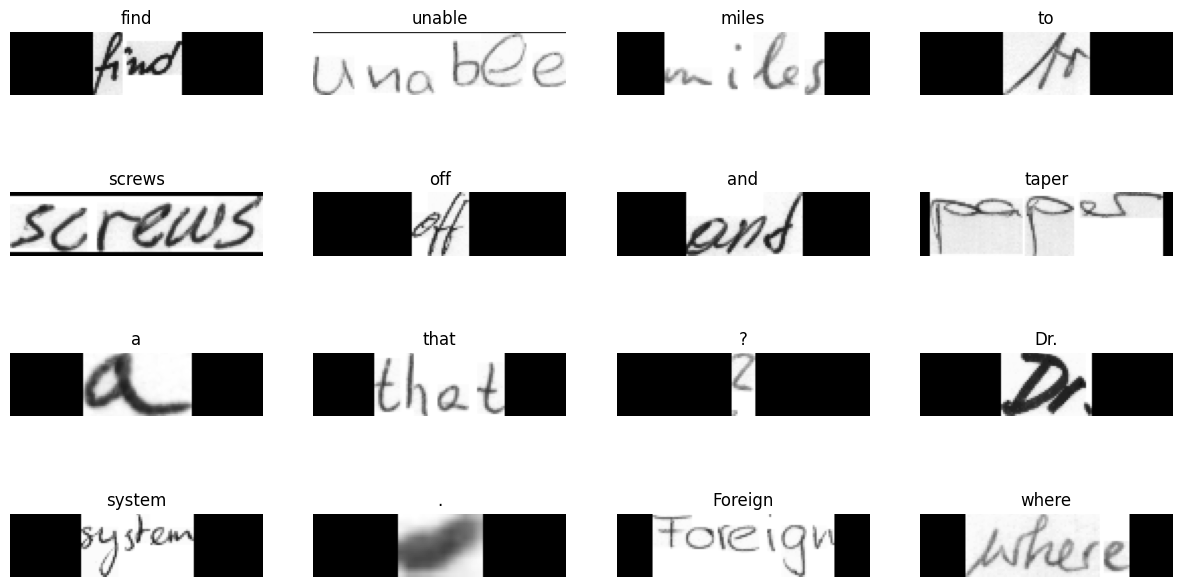

In [12]:
for data in dataset.skip(797).take(1):
    images, labels = data["image"], data["label"]
    print(images.shape, labels.shape)

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()